### Audio Load by Barney

In [1]:
from barney_functions import *
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import soundfile as sf
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [43]:
mels = np.load('mels.npz')['data']
y = np.load('mels_lables.npz',allow_pickle=True)['data']
num_classes = len(np.unique(y))

TEST_images = np.load('mels_TEST.npz')['data']
TEST_y = np.load('mels_lables_TEST.npz',allow_pickle=True)['data']

BIG_images = np.load('mels_TRAIN_ALL.npz')['data']
BIG_y = np.load('mels_lables_TRAIN_ALL.npz',allow_pickle=True)['data']

mels, TEST_images, y, TEST_y = train_test_split(BIG_images, BIG_y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, img_rows, img_cols = format_for_CNN(train_images, val_images, train_labels, val_labels)

print(mels.shape)
print(y.shape)
print(TEST_images.shape)
print(TEST_y.shape)
print(BIG_images.shape)
print(BIG_y.shape)

(2256, 128, 51)
(2256,)
(1266, 128, 51)
(1266,)
(10512, 128, 51)
(10512,)


# CNN

In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from sklearn.model_selection import KFold

In [7]:
import optuna

In [8]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


# Optimising

In [16]:
def objective(trial):
    n_epochs = trial.suggest_int("n_epochs", low=5, high=50, step=5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3)
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = trial.suggest_int("filters_1",low=2,high=32,step=2)
    kernel_1 = trial.suggest_int("kernel_size_1",low=8,high=16,step=4)
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = 2
    
    filters_2 = trial.suggest_int("filters_2",low=2,high=64,step=2)
    kernel_2 = trial.suggest_int("kernel_size_2",low=4,high=12,step=2)
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    pool_size_2 = 2
    
    dropout_rate = 0.4
    
    lin_1_n = trial.suggest_int("lin_1_n",low=4,high=128,step=1)
    
    batch_size = 128
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5),
        TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_test, y_test),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score
# changed trials to 50 from 10
# removed pruning but not callbacks

In [17]:
train_images, val_images, train_labels, val_labels = train_test_split(mels, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, img_rows, img_cols = format_for_CNN(train_images, val_images, train_labels, val_labels)
check_class_complete_gen(train_labels, val_labels,y)

OK


In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2022-06-10 19:49:27,182] A new study created in memory with name: no-name-1fe2600b-da5d-451e-875c-bf1e4697b732


Epoch 1/15
15/15 [==============================] - 9s 600ms/step - loss: 1.1905 - categorical_accuracy: 0.5006 - val_loss: 0.8859 - val_categorical_accuracy: 0.5664
Epoch 2/15
15/15 [==============================] - 9s 604ms/step - loss: 0.7952 - categorical_accuracy: 0.6447 - val_loss: 0.6749 - val_categorical_accuracy: 0.6637
Epoch 3/15
15/15 [==============================] - 9s 620ms/step - loss: 0.7015 - categorical_accuracy: 0.6829 - val_loss: 0.5776 - val_categorical_accuracy: 0.7677
Epoch 4/15
15/15 [==============================] - 10s 627ms/step - loss: 0.5944 - categorical_accuracy: 0.7528 - val_loss: 0.5200 - val_categorical_accuracy: 0.7544
Epoch 5/15
15/15 [==============================] - 9s 624ms/step - loss: 0.4901 - categorical_accuracy: 0.7932 - val_loss: 0.4166 - val_categorical_accuracy: 0.8363
Epoch 6/15
15/15 [==============================] - 9s 623ms/step - loss: 0.4428 - categorical_accuracy: 0.8132 - val_loss: 0.3785 - val_categorical_accuracy: 0.8562
Epo

[I 2022-06-10 19:51:45,826] Trial 0 finished with value: 0.9070796370506287 and parameters: {'n_epochs': 15, 'learning_rate': 0.0007782035648105175, 'filters_1': 32, 'kernel_size_1': 12, 'filters_2': 8, 'kernel_size_2': 4, 'lin_1_n': 30}. Best is trial 0 with value: 0.9070796370506287.


Epoch 1/25
15/15 [==============================] - 11s 738ms/step - loss: 0.9672 - categorical_accuracy: 0.5765 - val_loss: 0.6782 - val_categorical_accuracy: 0.7124
Epoch 2/25
15/15 [==============================] - 11s 721ms/step - loss: 0.6321 - categorical_accuracy: 0.7345 - val_loss: 0.5814 - val_categorical_accuracy: 0.7611
Epoch 3/25
15/15 [==============================] - 11s 729ms/step - loss: 0.4736 - categorical_accuracy: 0.7943 - val_loss: 0.4618 - val_categorical_accuracy: 0.8075
Epoch 4/25
15/15 [==============================] - 11s 729ms/step - loss: 0.4161 - categorical_accuracy: 0.8381 - val_loss: 0.4240 - val_categorical_accuracy: 0.8097
Epoch 5/25
15/15 [==============================] - 11s 753ms/step - loss: 0.3823 - categorical_accuracy: 0.8392 - val_loss: 0.3276 - val_categorical_accuracy: 0.8827
Epoch 6/25
15/15 [==============================] - 13s 846ms/step - loss: 0.3188 - categorical_accuracy: 0.8697 - val_loss: 0.3083 - val_categorical_accuracy: 0.873

[I 2022-06-10 19:56:29,286] Trial 1 finished with value: 0.9646017551422119 and parameters: {'n_epochs': 25, 'learning_rate': 0.000612136233949471, 'filters_1': 4, 'kernel_size_1': 16, 'filters_2': 26, 'kernel_size_2': 4, 'lin_1_n': 43}. Best is trial 1 with value: 0.9646017551422119.


Epoch 1/50
15/15 [==============================] - 17s 1s/step - loss: 1.1452 - categorical_accuracy: 0.4950 - val_loss: 0.7721 - val_categorical_accuracy: 0.6305
Epoch 2/50
15/15 [==============================] - 17s 1s/step - loss: 0.6982 - categorical_accuracy: 0.6868 - val_loss: 0.5936 - val_categorical_accuracy: 0.7367
Epoch 3/50
15/15 [==============================] - 17s 1s/step - loss: 0.5774 - categorical_accuracy: 0.7533 - val_loss: 0.5946 - val_categorical_accuracy: 0.7323
Epoch 4/50
15/15 [==============================] - 17s 1s/step - loss: 0.5664 - categorical_accuracy: 0.7384 - val_loss: 0.4771 - val_categorical_accuracy: 0.7788
Epoch 5/50
15/15 [==============================] - 17s 1s/step - loss: 0.4956 - categorical_accuracy: 0.7783 - val_loss: 0.5420 - val_categorical_accuracy: 0.7257
Epoch 6/50
15/15 [==============================] - 17s 1s/step - loss: 0.4950 - categorical_accuracy: 0.7772 - val_loss: 0.4387 - val_categorical_accuracy: 0.8053
Epoch 7/50
15/15

[I 2022-06-10 20:11:04,765] Trial 2 finished with value: 0.9756637215614319 and parameters: {'n_epochs': 50, 'learning_rate': 0.0009409357780120208, 'filters_1': 22, 'kernel_size_1': 16, 'filters_2': 30, 'kernel_size_2': 8, 'lin_1_n': 23}. Best is trial 2 with value: 0.9756637215614319.


Epoch 1/30
15/15 [==============================] - 5s 310ms/step - loss: 1.1108 - categorical_accuracy: 0.4867 - val_loss: 0.7785 - val_categorical_accuracy: 0.6195
Epoch 2/30
15/15 [==============================] - 5s 304ms/step - loss: 0.7238 - categorical_accuracy: 0.6685 - val_loss: 0.6244 - val_categorical_accuracy: 0.7146
Epoch 3/30
15/15 [==============================] - 5s 302ms/step - loss: 0.5926 - categorical_accuracy: 0.7506 - val_loss: 0.5389 - val_categorical_accuracy: 0.7854
Epoch 4/30
15/15 [==============================] - 5s 300ms/step - loss: 0.5129 - categorical_accuracy: 0.7999 - val_loss: 0.4557 - val_categorical_accuracy: 0.7920
Epoch 5/30
15/15 [==============================] - 5s 300ms/step - loss: 0.4419 - categorical_accuracy: 0.8082 - val_loss: 0.4002 - val_categorical_accuracy: 0.8496
Epoch 6/30
15/15 [==============================] - 5s 301ms/step - loss: 0.4057 - categorical_accuracy: 0.8309 - val_loss: 0.3887 - val_categorical_accuracy: 0.8385
Epoc

[I 2022-06-10 20:13:21,837] Trial 3 finished with value: 0.9469026327133179 and parameters: {'n_epochs': 30, 'learning_rate': 0.000724726306844754, 'filters_1': 4, 'kernel_size_1': 8, 'filters_2': 22, 'kernel_size_2': 8, 'lin_1_n': 65}. Best is trial 2 with value: 0.9756637215614319.


Epoch 1/30
15/15 [==============================] - 13s 842ms/step - loss: 1.0572 - categorical_accuracy: 0.5050 - val_loss: 0.8042 - val_categorical_accuracy: 0.6615
Epoch 2/30
15/15 [==============================] - 13s 838ms/step - loss: 0.6855 - categorical_accuracy: 0.6885 - val_loss: 0.6250 - val_categorical_accuracy: 0.7124
Epoch 3/30
15/15 [==============================] - 13s 851ms/step - loss: 0.6004 - categorical_accuracy: 0.7373 - val_loss: 0.5365 - val_categorical_accuracy: 0.7677
Epoch 4/30
15/15 [==============================] - 13s 835ms/step - loss: 0.4994 - categorical_accuracy: 0.7822 - val_loss: 0.4380 - val_categorical_accuracy: 0.8097
Epoch 5/30
15/15 [==============================] - 12s 831ms/step - loss: 0.4096 - categorical_accuracy: 0.8176 - val_loss: 0.3911 - val_categorical_accuracy: 0.8164
Epoch 6/30
15/15 [==============================] - 13s 836ms/step - loss: 0.3384 - categorical_accuracy: 0.8570 - val_loss: 0.3381 - val_categorical_accuracy: 0.867

[I 2022-06-10 20:19:39,819] Trial 4 finished with value: 0.982300877571106 and parameters: {'n_epochs': 30, 'learning_rate': 0.0008471407179357993, 'filters_1': 24, 'kernel_size_1': 8, 'filters_2': 48, 'kernel_size_2': 8, 'lin_1_n': 33}. Best is trial 4 with value: 0.982300877571106.


Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.2985 - categorical_accuracy: 0.3997

[I 2022-06-10 20:19:48,972] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 1.1993 - categorical_accuracy: 0.4579

[I 2022-06-10 20:20:03,511] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 1.0898 - categorical_accuracy: 0.5116

[I 2022-06-10 20:20:24,363] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/30
15/15 [==============================] - 11s 693ms/step - loss: 1.0918 - categorical_accuracy: 0.5072 - val_loss: 0.7787 - val_categorical_accuracy: 0.6350
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.7288 - categorical_accuracy: 0.6774

[I 2022-06-10 20:20:45,517] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/50
15/15 [==============================] - 19s 1s/step - loss: 1.1312 - categorical_accuracy: 0.4468 - val_loss: 0.8279 - val_categorical_accuracy: 0.6527
Epoch 2/50
15/15 [==============================] - 19s 1s/step - loss: 0.7882 - categorical_accuracy: 0.6674 - val_loss: 0.6274 - val_categorical_accuracy: 0.7279
Epoch 3/50
15/15 [==============================] - 19s 1s/step - loss: 0.5934 - categorical_accuracy: 0.7461 - val_loss: 0.4788 - val_categorical_accuracy: 0.7965
Epoch 4/50
15/15 [==============================] - 19s 1s/step - loss: 0.5198 - categorical_accuracy: 0.7683 - val_loss: 0.4214 - val_categorical_accuracy: 0.8208
Epoch 5/50
15/15 [==============================] - ETA: 0s - loss: 0.4597 - categorical_accuracy: 0.8054

[I 2022-06-10 20:22:20,446] Trial 9 pruned. Trial was pruned at epoch 4.


Epoch 1/40
15/15 [==============================] - 36s 2s/step - loss: 1.1654 - categorical_accuracy: 0.4778 - val_loss: 0.7365 - val_categorical_accuracy: 0.6659
Epoch 2/40
15/15 [==============================] - 31s 2s/step - loss: 0.6612 - categorical_accuracy: 0.7034 - val_loss: 0.5574 - val_categorical_accuracy: 0.7633
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.5388 - categorical_accuracy: 0.7688

[I 2022-06-10 20:23:58,689] Trial 10 pruned. Trial was pruned at epoch 2.


Epoch 1/40
15/15 [==============================] - 12s 767ms/step - loss: 1.2638 - categorical_accuracy: 0.4357 - val_loss: 0.7721 - val_categorical_accuracy: 0.6305
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.7204 - categorical_accuracy: 0.7007

[I 2022-06-10 20:24:22,109] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/40
15/15 [==============================] - ETA: 0s - loss: 1.1385 - categorical_accuracy: 0.4972

[I 2022-06-10 20:24:38,085] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/35
15/15 [==============================] - 11s 726ms/step - loss: 0.8645 - categorical_accuracy: 0.5998 - val_loss: 0.5881 - val_categorical_accuracy: 0.7345
Epoch 2/35
15/15 [==============================] - 11s 719ms/step - loss: 0.5255 - categorical_accuracy: 0.7722 - val_loss: 0.4374 - val_categorical_accuracy: 0.7987
Epoch 3/35
15/15 [==============================] - 10s 660ms/step - loss: 0.3761 - categorical_accuracy: 0.8442 - val_loss: 0.3408 - val_categorical_accuracy: 0.8761
Epoch 4/35
15/15 [==============================] - 10s 682ms/step - loss: 0.2686 - categorical_accuracy: 0.8975 - val_loss: 0.2869 - val_categorical_accuracy: 0.9004
Epoch 5/35
15/15 [==============================] - 10s 667ms/step - loss: 0.2207 - categorical_accuracy: 0.9091 - val_loss: 0.3144 - val_categorical_accuracy: 0.8783
Epoch 6/35
15/15 [==============================] - 10s 662ms/step - loss: 0.1964 - categorical_accuracy: 0.9279 - val_loss: 0.2494 - val_categorical_accuracy: 0.889

[I 2022-06-10 20:29:26,133] Trial 13 finished with value: 0.9867256879806519 and parameters: {'n_epochs': 35, 'learning_rate': 0.0008577636577551398, 'filters_1': 28, 'kernel_size_1': 8, 'filters_2': 58, 'kernel_size_2': 6, 'lin_1_n': 40}. Best is trial 13 with value: 0.9867256879806519.


Epoch 1/35
15/15 [==============================] - 10s 661ms/step - loss: 1.1791 - categorical_accuracy: 0.4795 - val_loss: 0.7348 - val_categorical_accuracy: 0.6549
Epoch 2/35
15/15 [==============================] - 10s 652ms/step - loss: 0.6870 - categorical_accuracy: 0.7123 - val_loss: 0.5993 - val_categorical_accuracy: 0.7522
Epoch 3/35
15/15 [==============================] - 10s 656ms/step - loss: 0.5650 - categorical_accuracy: 0.7688 - val_loss: 0.4735 - val_categorical_accuracy: 0.8075
Epoch 4/35
15/15 [==============================] - 10s 653ms/step - loss: 0.4873 - categorical_accuracy: 0.7905 - val_loss: 0.4715 - val_categorical_accuracy: 0.7721
Epoch 5/35
15/15 [==============================] - 10s 651ms/step - loss: 0.4344 - categorical_accuracy: 0.8088 - val_loss: 0.3909 - val_categorical_accuracy: 0.8496
Epoch 6/35
15/15 [==============================] - ETA: 0s - loss: 0.3766 - categorical_accuracy: 0.8531

[I 2022-06-10 20:30:25,519] Trial 14 pruned. Trial was pruned at epoch 5.


Epoch 1/15
15/15 [==============================] - 11s 694ms/step - loss: 0.8605 - categorical_accuracy: 0.5881 - val_loss: 0.6183 - val_categorical_accuracy: 0.7035
Epoch 2/15
15/15 [==============================] - 10s 679ms/step - loss: 0.5300 - categorical_accuracy: 0.7788 - val_loss: 0.4286 - val_categorical_accuracy: 0.8142
Epoch 3/15
15/15 [==============================] - 10s 683ms/step - loss: 0.4181 - categorical_accuracy: 0.8315 - val_loss: 0.3926 - val_categorical_accuracy: 0.8540
Epoch 4/15
15/15 [==============================] - 10s 680ms/step - loss: 0.3251 - categorical_accuracy: 0.8686 - val_loss: 0.2872 - val_categorical_accuracy: 0.8916
Epoch 5/15
15/15 [==============================] - 10s 678ms/step - loss: 0.2588 - categorical_accuracy: 0.9008 - val_loss: 0.2467 - val_categorical_accuracy: 0.9115
Epoch 6/15
15/15 [==============================] - 10s 685ms/step - loss: 0.1930 - categorical_accuracy: 0.9263 - val_loss: 0.2125 - val_categorical_accuracy: 0.915

[I 2022-06-10 20:33:04,398] Trial 15 finished with value: 0.9734513163566589 and parameters: {'n_epochs': 15, 'learning_rate': 0.0008519790059661107, 'filters_1': 30, 'kernel_size_1': 8, 'filters_2': 54, 'kernel_size_2': 6, 'lin_1_n': 65}. Best is trial 13 with value: 0.9867256879806519.


Epoch 1/25
15/15 [==============================] - 7s 428ms/step - loss: 1.1695 - categorical_accuracy: 0.5044 - val_loss: 0.7948 - val_categorical_accuracy: 0.6748
Epoch 2/25
15/15 [==============================] - 6s 422ms/step - loss: 0.6904 - categorical_accuracy: 0.7090 - val_loss: 0.5640 - val_categorical_accuracy: 0.7743
Epoch 3/25
15/15 [==============================] - 6s 424ms/step - loss: 0.4880 - categorical_accuracy: 0.8060 - val_loss: 0.4247 - val_categorical_accuracy: 0.8186
Epoch 4/25
15/15 [==============================] - 6s 427ms/step - loss: 0.3652 - categorical_accuracy: 0.8592 - val_loss: 0.4246 - val_categorical_accuracy: 0.8119
Epoch 5/25
15/15 [==============================] - 7s 442ms/step - loss: 0.3063 - categorical_accuracy: 0.8792 - val_loss: 0.3178 - val_categorical_accuracy: 0.8717
Epoch 6/25
15/15 [==============================] - 7s 438ms/step - loss: 0.2762 - categorical_accuracy: 0.8958 - val_loss: 0.3028 - val_categorical_accuracy: 0.8894
Epoc

[I 2022-06-10 20:33:50,195] Trial 16 pruned. Trial was pruned at epoch 6.


Epoch 1/35
15/15 [==============================] - ETA: 0s - loss: 1.0861 - categorical_accuracy: 0.5238

[I 2022-06-10 20:34:03,212] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/5
15/15 [==============================] - 14s 880ms/step - loss: 1.2589 - categorical_accuracy: 0.4839 - val_loss: 0.7311 - val_categorical_accuracy: 0.6969
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.6709 - categorical_accuracy: 0.7239

[I 2022-06-10 20:34:29,978] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/45
15/15 [==============================] - ETA: 0s - loss: 1.1844 - categorical_accuracy: 0.4102

[I 2022-06-10 20:34:47,499] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/35
15/15 [==============================] - 8s 540ms/step - loss: 1.1227 - categorical_accuracy: 0.5338 - val_loss: 0.7360 - val_categorical_accuracy: 0.6637
Epoch 2/35
15/15 [==============================] - 8s 533ms/step - loss: 0.6674 - categorical_accuracy: 0.7156 - val_loss: 0.5503 - val_categorical_accuracy: 0.7522
Epoch 3/35
15/15 [==============================] - 8s 547ms/step - loss: 0.5243 - categorical_accuracy: 0.7833 - val_loss: 0.4517 - val_categorical_accuracy: 0.8119
Epoch 4/35
15/15 [==============================] - 8s 536ms/step - loss: 0.4188 - categorical_accuracy: 0.8348 - val_loss: 0.3654 - val_categorical_accuracy: 0.8540
Epoch 5/35
15/15 [==============================] - 8s 543ms/step - loss: 0.3419 - categorical_accuracy: 0.8487 - val_loss: 0.3241 - val_categorical_accuracy: 0.8739
Epoch 6/35
15/15 [==============================] - 8s 549ms/step - loss: 0.2786 - categorical_accuracy: 0.8864 - val_loss: 0.3188 - val_categorical_accuracy: 0.9093
Epoc

[I 2022-06-10 20:39:29,434] Trial 20 finished with value: 0.9933628439903259 and parameters: {'n_epochs': 35, 'learning_rate': 0.0006920615808798661, 'filters_1': 20, 'kernel_size_1': 8, 'filters_2': 48, 'kernel_size_2': 6, 'lin_1_n': 79}. Best is trial 20 with value: 0.9933628439903259.


Epoch 1/35
15/15 [==============================] - 9s 573ms/step - loss: 1.1301 - categorical_accuracy: 0.4939 - val_loss: 0.7150 - val_categorical_accuracy: 0.6858
Epoch 2/35
15/15 [==============================] - 8s 561ms/step - loss: 0.6372 - categorical_accuracy: 0.7278 - val_loss: 0.5765 - val_categorical_accuracy: 0.7611
Epoch 3/35
15/15 [==============================] - ETA: 0s - loss: 0.4970 - categorical_accuracy: 0.7899

[I 2022-06-10 20:39:55,381] Trial 21 pruned. Trial was pruned at epoch 2.


Epoch 1/30
15/15 [==============================] - 15s 954ms/step - loss: 1.2220 - categorical_accuracy: 0.4584 - val_loss: 0.7243 - val_categorical_accuracy: 0.6726
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.6697 - categorical_accuracy: 0.7206

[I 2022-06-10 20:40:24,373] Trial 22 pruned. Trial was pruned at epoch 1.


Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.1116 - categorical_accuracy: 0.5139

[I 2022-06-10 20:40:30,966] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/35
15/15 [==============================] - ETA: 0s - loss: 1.1740 - categorical_accuracy: 0.4318

[I 2022-06-10 20:40:44,957] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/45
15/15 [==============================] - ETA: 0s - loss: 1.1446 - categorical_accuracy: 0.5200

[I 2022-06-10 20:41:01,599] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/25
15/15 [==============================] - 10s 641ms/step - loss: 0.8596 - categorical_accuracy: 0.6098 - val_loss: 0.6030 - val_categorical_accuracy: 0.7212
Epoch 2/25
15/15 [==============================] - 9s 602ms/step - loss: 0.5247 - categorical_accuracy: 0.7794 - val_loss: 0.4021 - val_categorical_accuracy: 0.8230
Epoch 3/25
15/15 [==============================] - 9s 625ms/step - loss: 0.4037 - categorical_accuracy: 0.8254 - val_loss: 0.3344 - val_categorical_accuracy: 0.8650
Epoch 4/25
15/15 [==============================] - 9s 620ms/step - loss: 0.2901 - categorical_accuracy: 0.8786 - val_loss: 0.2549 - val_categorical_accuracy: 0.9093
Epoch 5/25
15/15 [==============================] - 9s 613ms/step - loss: 0.2077 - categorical_accuracy: 0.9257 - val_loss: 0.2180 - val_categorical_accuracy: 0.9115
Epoch 6/25
15/15 [==============================] - 9s 606ms/step - loss: 0.1726 - categorical_accuracy: 0.9385 - val_loss: 0.1713 - val_categorical_accuracy: 0.9513
Epo

[I 2022-06-10 20:44:48,814] Trial 26 finished with value: 0.9867256879806519 and parameters: {'n_epochs': 25, 'learning_rate': 0.0009041484918678552, 'filters_1': 10, 'kernel_size_1': 12, 'filters_2': 52, 'kernel_size_2': 6, 'lin_1_n': 98}. Best is trial 20 with value: 0.9933628439903259.


Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.1151 - categorical_accuracy: 0.5067

[I 2022-06-10 20:44:57,204] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/25
15/15 [==============================] - 10s 616ms/step - loss: 1.0665 - categorical_accuracy: 0.5654 - val_loss: 0.6672 - val_categorical_accuracy: 0.7323
Epoch 2/25
15/15 [==============================] - 9s 602ms/step - loss: 0.6194 - categorical_accuracy: 0.7539 - val_loss: 0.5554 - val_categorical_accuracy: 0.7699
Epoch 3/25
15/15 [==============================] - 9s 616ms/step - loss: 0.5006 - categorical_accuracy: 0.7905 - val_loss: 0.4406 - val_categorical_accuracy: 0.8142
Epoch 4/25
15/15 [==============================] - 9s 611ms/step - loss: 0.3994 - categorical_accuracy: 0.8271 - val_loss: 0.3342 - val_categorical_accuracy: 0.8761
Epoch 5/25
15/15 [==============================] - 9s 618ms/step - loss: 0.3126 - categorical_accuracy: 0.8803 - val_loss: 0.3736 - val_categorical_accuracy: 0.8164
Epoch 6/25
15/15 [==============================] - 9s 612ms/step - loss: 0.2892 - categorical_accuracy: 0.8875 - val_loss: 0.2873 - val_categorical_accuracy: 0.8805
Epo

[I 2022-06-10 20:48:46,605] Trial 28 finished with value: 0.9756637215614319 and parameters: {'n_epochs': 25, 'learning_rate': 0.000915452093854009, 'filters_1': 6, 'kernel_size_1': 12, 'filters_2': 42, 'kernel_size_2': 6, 'lin_1_n': 117}. Best is trial 20 with value: 0.9933628439903259.


Epoch 1/45
15/15 [==============================] - 8s 527ms/step - loss: 0.9868 - categorical_accuracy: 0.5721 - val_loss: 0.6730 - val_categorical_accuracy: 0.7035
Epoch 2/45
15/15 [==============================] - 8s 528ms/step - loss: 0.6284 - categorical_accuracy: 0.7350 - val_loss: 0.5242 - val_categorical_accuracy: 0.7633
Epoch 3/45
15/15 [==============================] - 8s 533ms/step - loss: 0.4854 - categorical_accuracy: 0.7894 - val_loss: 0.4266 - val_categorical_accuracy: 0.8097
Epoch 4/45
15/15 [==============================] - ETA: 0s - loss: 0.4223 - categorical_accuracy: 0.8248

[I 2022-06-10 20:49:18,875] Trial 29 pruned. Trial was pruned at epoch 3.


In [19]:
optimised_params = study.best_params
print(optimised_params)

{'n_epochs': 35, 'learning_rate': 0.0006920615808798661, 'filters_1': 20, 'kernel_size_1': 8, 'filters_2': 48, 'kernel_size_2': 6, 'lin_1_n': 79}


In [20]:
def opt_model(optimised_params):
    n_epochs = optimised_params['n_epochs']
    learning_rate = optimised_params['learning_rate']
    optimiser = Adam(learning_rate=learning_rate)
    # Conv 1
    filters_1 = optimised_params['filters_1']
    kernel_size_1 = optimised_params['kernel_size_1']
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = 2
    # Conv 2
    filters_2 = optimised_params['filters_2']
    kernel_size_2 = optimised_params['kernel_size_2']
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    # Pool 2
    pool_size_2 = 2
    # Droput
    dropout_rate = 0.4
    # Lin 1
    lin_1_n = optimised_params['lin_1_n']
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    return model

# Folding

In [45]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
X = mels
y = y 
# Human Optimisation...
check_class_complete(kfold,X,y)
#optimised_params['learning_rate'] = 0.0014280245429123698/2
#optimised_params['n_epochs'] = 30
n_epochs = optimised_params['n_epochs']
fold_loss = np.zeros((n_folds,n_epochs))
np.save('optimised_params',optimised_params)
print(optimised_params)

ALL CLASSES PRESENT
{'n_epochs': 35, 'learning_rate': 0.0006920615808798661, 'filters_1': 20, 'kernel_size_1': 8, 'filters_2': 48, 'kernel_size_2': 6, 'lin_1_n': 79}


In [46]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,X_test,y_train,y_test, img_rows, img_cols = format_for_CNN(X_train,X_test,y_train,y_test)
    
    model = opt_model(optimised_params)

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

-----------------------------------
FOLD 1
-----------------------------------
Epoch 1/35
53/53 [==============================] - 27s 508ms/step - loss: 0.6257 - categorical_accuracy: 0.7656 - val_loss: 0.3744 - val_categorical_accuracy: 0.8514
Epoch 2/35
53/53 [==============================] - 27s 519ms/step - loss: 0.3403 - categorical_accuracy: 0.8555 - val_loss: 0.2862 - val_categorical_accuracy: 0.8835
Epoch 3/35
53/53 [==============================] - 28s 531ms/step - loss: 0.2527 - categorical_accuracy: 0.8971 - val_loss: 0.2000 - val_categorical_accuracy: 0.9287
Epoch 4/35
53/53 [==============================] - 28s 525ms/step - loss: 0.2017 - categorical_accuracy: 0.9171 - val_loss: 0.1519 - val_categorical_accuracy: 0.9429
Epoch 5/35
53/53 [==============================] - 28s 522ms/step - loss: 0.1499 - categorical_accuracy: 0.9410 - val_loss: 0.1232 - val_categorical_accuracy: 0.9560
Epoch 6/35
53/53 [==============================] - 28s 520ms/step - loss: 0.1252 - ca

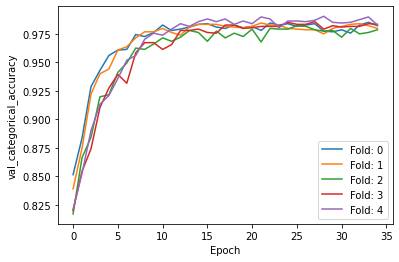

Mean val_categorical_accuracy:  0.98133


In [47]:
for i in range(n_folds):
    plt.plot(fold_loss[i], label='Fold: '+str(i))
plt.xlabel('Epoch')
plt.ylabel('val_categorical_accuracy')
plt.legend()
plt.show()
mean_acc = np.mean(fold_loss[:,-1])
print('Mean val_categorical_accuracy: ',np.around(mean_acc,5))

1st convolution layer: 20 x 8


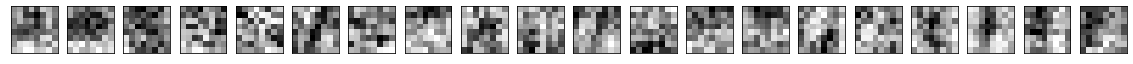

2nd convolution layer: 48 x 6


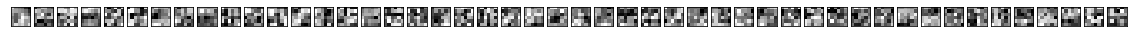

In [65]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

n_1 = optimised_params['filters_1']
print('1st convolution layer:',n_1,'x',optimised_params['kernel_size_1'])
fig, axs = plt.subplots(1,n_1, figsize=(20, 20))
axs = axs.ravel()
for i in range(n_1):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

n_2 = optimised_params['filters_2']
print('2nd convolution layer:',n_2,'x',optimised_params['kernel_size_2'])
fig, axs = plt.subplots(1,n_2, figsize=(20, 50))
axs = axs.ravel()
for i in range(n_2):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [74]:
mels = np.load('mels.npz')['data']
y = np.load('mels_lables.npz',allow_pickle=True)['data']
num_classes = len(np.unique(y))

TEST_images = np.load('mels_TEST.npz')['data']
TEST_y = np.load('mels_lables_TEST.npz',allow_pickle=True)['data']

BIG_images = np.load('mels_TRAIN_ALL.npz')['data']
BIG_y = np.load('mels_lables_TRAIN_ALL.npz',allow_pickle=True)['data']

print(mels.shape)
print(y.shape)
print(TEST_images.shape)
print(TEST_y.shape)
print(BIG_images.shape)
print(BIG_y.shape)

(2256, 128, 51)
(2256,)
(1266, 128, 51)
(1266,)
(10512, 128, 51)
(10512,)


In [ ]:
_, TEST_images, y, TEST_y = train_test_split(BIG_images, BIG_y, test_size=0.2, random_state=42)
_, X_test, _, y_test, _, _ = format_for_CNN(TEST_images, val_images, train_labels, val_labels)

In [82]:
print(TEST_images.shape)
print(X_test.shape)

(2103, 128, 51)
(452, 128, 51, 1)


In [79]:
predicted_prob = model.predict(TEST_images)
predictions = np.argmax(predicted_prob, axis=1)

In [80]:
print(predictions.shape)
print(TEST_y.shape)

(2103,)
(2103,)


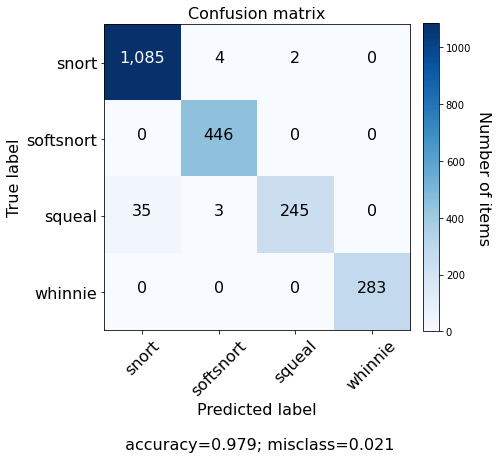

In [81]:
labels_list = np.unique(y)
onehot_v = pd.get_dummies(TEST_y)
onehot_y = onehot_v.to_numpy()
truths = np.argmax(onehot_y, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
plot_confusion_matrix(cm,labels_list,normalize=False,savefig = 'CM_CNN_OPT')